<h1 align="center">Loan Default Prediction report - Lending Club case study</h1>

**Submitted by:** Hasnath  

LendingClub is one of the largest peer-to-peer (P2P) lending platforms in the United States. Founded in 2006, it connects individual borrowers seeking personal loans with investors looking to fund them. By removing traditional banks as intermediaries, LendingClub aims to offer competitive interest rates for borrowers while providing attractive returns for investors.

However, this business model comes with inherent credit risk. Loan defaults reduce investor returns and affect the platform’s credibility and profitability. Therefore, it is essential to assess borrower risk accurately before approving loans.

**Objective**

The objective of this analysis is to build and evaluate classification models to predict **loan default probability** using LendingClub’s borrower-level data. The analysis covers:

1. Data preprocessing (handling missing values, encoding, scaling)  
2. Bivariate analysis of predictors vs default  
3. Model building (Logistic Regression, Decision Tree, Random Forest)  
4. Identification of top 5 default predictors  
5. Model evaluation using Accuracy, Precision, Recall, F1-score, and ROC-AUC  
6. Insights and recommendations for credit risk management

In [10]:
# Step 1: Setup, Imports & Load Dataset

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

# ✅ Set your file path safely
INPUT_CSV = r"D:\Lending_Club_Loan_Data_Sep2025.csv"

# Check if file exists
if not os.path.exists(INPUT_CSV):
    raise FileNotFoundError(f"File not found: {INPUT_CSV}")
else:
    print(f"✅ File found: {INPUT_CSV}")

# Load the dataset
df = pd.read_csv(INPUT_CSV, low_memory=False)
print("✅ Data loaded successfully!")
print("Shape of dataset:", df.shape)

# Display a few rows
df.head(5)


✅ File found: D:\Lending_Club_Loan_Data_Sep2025.csv
✅ Data loaded successfully!
Shape of dataset: (39717, 109)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,NaN,10+ years,RENT,24000.0,Verified,11-Dec,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.0,0.0,5863.155187,5833.84,5000.0,863.16,0.00,0.0,0.0,15-Jan,171.62,NaN,16-May,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,NaN,10+ years,RENT,12252.0,Not Verified,11-Dec,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,1-Nov,2,NaN,NaN,2,0,2956,98.50%,10,f,0.0,0.0,3005.666844,3005.67,2400.0,605.67,0.00,0.0,0.0,14-Jun,649.91,NaN,16-May,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,11-Dec,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,f,0.0,0.0,12231.890000,12231.89,10000.0,2214.92,16.97,0.0,0.0,15-Jan,357.48,NaN,16-Apr,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1075269,1311441,5000,5000,5000.0,36 months,7.90%,156.46,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,11-Dec,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0,4-Nov,3,NaN,NaN,9,0,7963,28.30%,12,f,0.0,0.0,5632.210000,5632.21,5000.0,632.21,0.00,0.0,0.0,15-Jan,161.03,NaN,16-Jan,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [12]:
# Step 2: Initial Data Understanding + Target Creation

# 1️⃣ Check basic dataset information
print("=== Dataset Info ===")
df.info()

print("\n=== Missing Value Summary (Top 20 Columns) ===")
print(df.isna().sum().sort_values(ascending=False).head(20))

print("\n=== Sample Records ===")
display(df.head(5))

# 2️⃣ Create binary target variable: is_default
# Loan status values typically include 'Fully Paid', 'Charged Off', 'Current', etc.
def map_loan_status(status):
    if pd.isna(status):
        return np.nan
    s = str(status).lower()
    if ("charged" in s) or ("default" in s) or ("late" in s and any(x in s for x in ["31", "60", "90", "120"])):
        return 1        # default / charged off / late
    elif ("fully paid" in s) or ("current" in s) or ("paid" in s and "charged" not in s):
        return 0        # good loans
    else:
        return np.nan   # other / unknown statuses

# Apply mapping
df["is_default"] = df["loan_status"].apply(map_loan_status)

# 3️⃣ Display new column distribution
print("\n=== Target Variable Distribution (is_default) ===")
print(df["is_default"].value_counts(dropna=False))
print("\nDefault rate: {:.2f}%".format(df["is_default"].mean() * 100))

# 4️⃣ Drop rows where target is missing (optional cleanup)
before = df.shape[0]
df = df.dropna(subset=["is_default"]).copy()
after = df.shape[0]
print(f"\nRows before: {before}, after removing missing target: {after}")

# Quick check of unique loan_status values to understand mapping
print("\n=== Unique Loan Status Values (Top 15) ===")
print(df["loan_status"].value_counts().head(15))


=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 109 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(22)
memory usage: 33.0+ MB

=== Missing Value Summary (Top 20 Columns) ===
total_il_high_credit_limit     39717
verification_status_joint      39717
inq_fi                         39717
mo_sin_rcnt_tl                 39717
mo_sin_rcnt_rev_tl_op          39717
mo_sin_old_rev_tl_op           39717
mo_sin_old_il_acct             39717
bc_util                        39717
bc_open_to_buy                 39717
avg_cur_bal                    39717
mths_since_last_major_derog    39717
acc_open_past_24mths           39717
inq_last_12m                   39717
annual_inc_joint               39717
dti_joint                      39717
total_cu_tl                    39717
mths_since_recent_bc_dlq       39717
tot_coll_amt                   39717
tot_cur_bal                    39717
open_acc_6m                    

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,NaN,10+ years,RENT,24000.0,Verified,11-Dec,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.0,0.0,5863.155187,5833.84,5000.0,863.16,0.00,0.0,0.0,15-Jan,171.62,NaN,16-May,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,NaN,10+ years,RENT,12252.0,Not Verified,11-Dec,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,1-Nov,2,NaN,NaN,2,0,2956,98.50%,10,f,0.0,0.0,3005.666844,3005.67,2400.0,605.67,0.00,0.0,0.0,14-Jun,649.91,NaN,16-May,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,11-Dec,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,f,0.0,0.0,12231.890000,12231.89,10000.0,2214.92,16.97,0.0,0.0,15-Jan,357.48,NaN,16-Apr,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1075269,1311441,5000,5000,5000.0,36 months,7.90%,156.46,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,11-Dec,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0,4-Nov,3,NaN,NaN,9,0,7963,28.30%,12,f,0.0,0.0,5632.210000,5632.21,5000.0,632.21,0.00,0.0,0.0,15-Jan,161.03,NaN,16-Jan,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


=== Target Variable Distribution (is_default) ===
is_default
0    34090
1     5627
Name: count, dtype: int64

Default rate: 14.17%

Rows before: 39717, after removing missing target: 39717

=== Unique Loan Status Values (Top 15) ===
loan_status
Fully Paid     32950
Charged Off     5627
Current         1140
Name: count, dtype: int64


In [14]:
# Step 3: Feature Selection & Initial Cleaning

import re

# 1️⃣ Choose relevant columns for modeling
# These are the main predictors typically used in LendingClub loan default models
selected_columns = [
    "loan_amnt", "term", "int_rate", "installment", "grade", "sub_grade",
    "emp_length", "home_ownership", "annual_inc", "verification_status",
    "purpose", "addr_state", "dti", "delinq_2yrs", "fico_range_low", "fico_range_high",
    "open_acc", "total_acc", "revol_bal", "revol_util", "collections_12_mths_ex_med"
]

# Keep only columns that exist in your dataset
available_features = [col for col in selected_columns if col in df.columns]
print("✅ Using features:", available_features)

# Create working copy
work = df[available_features + ["is_default"]].copy()

print("\nInitial working DataFrame shape:", work.shape)
display(work.head(5))


✅ Using features: ['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'open_acc', 'total_acc', 'revol_bal', 'revol_util', 'collections_12_mths_ex_med']

Initial working DataFrame shape: (39717, 18)


,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,open_acc,total_acc,revol_bal,revol_util,collections_12_mths_ex_med,is_default
0,5000,36 months,10.65%,162.87,10+ years,RENT,24000.0,Verified,credit_card,AZ,27.65,0,3,9,13648,83.70%,0.0,0
1,2400,36 months,15.96%,84.33,10+ years,RENT,12252.0,Not Verified,small_business,IL,8.72,0,2,10,2956,98.50%,0.0,0
2,10000,36 months,13.49%,339.31,10+ years,RENT,49200.0,Source Verified,other,CA,20.00,0,10,37,5598,21%,0.0,0
3,5000,36 months,7.90%,156.46,3 years,RENT,36000.0,Source Verified,wedding,AZ,11.20,0,9,12,7963,28.30%,0.0,0
4,3000,36 months,18.64%,109.43,9 years,RENT,48000.0,Source Verified,car,CA,5.35,0,4,4,8221,87.50%,0.0,0


In [18]:
# Step 3.1: Clean columns like 'int_rate', 'term', and 'emp_length'

# Convert percentage strings (e.g. '13.5%') to numeric
def percent_to_float(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().replace("%", "")
    try:
        return float(s)
    except:
        return np.nan

if "int_rate" in work.columns:
    work["int_rate"] = work["int_rate"].apply(percent_to_float)

if "revol_util" in work.columns:
    work["revol_util"] = work["revol_util"].apply(percent_to_float)

# Convert 'term' like '36 months' to numeric (e.g. 36)
if "term" in work.columns:
    work["term_months"] = work["term"].astype(str).str.extract(r"(\d+)").astype(float)
    work.drop(columns=["term"], inplace=True)

# Convert employment length to numeric years (e.g. "10+ years" → 10)
if "emp_length" in work.columns:
    def emp_to_years(x):
        if pd.isna(x):
            return np.nan
        s = str(x)
        if "<" in s:
            return 0.5
        m = re.search(r"(\d+)", s)
        return float(m.group(1)) if m else np.nan

    work["emp_length_num"] = work["emp_length"].apply(emp_to_years)
    work.drop(columns=["emp_length"], inplace=True)


In [20]:
# Step 3.2: Check and handle missing values

missing = work.isna().mean().sort_values(ascending=False)
print("=== Missing Value Fraction (Top 15) ===")
print(missing.head(15))

# For now, drop rows with too many missing values (>50% missing features)
work = work.dropna(thresh=len(work.columns) * 0.5)
print("\nShape after dropping heavily missing rows:", work.shape)


=== Missing Value Fraction (Top 15) ===
emp_length_num                0.027066
collections_12_mths_ex_med    0.001410
revol_util                    0.001259
int_rate                      0.000000
term_months                   0.000000
is_default                    0.000000
revol_bal                     0.000000
total_acc                     0.000000
open_acc                      0.000000
loan_amnt                     0.000000
dti                           0.000000
addr_state                    0.000000
purpose                       0.000000
verification_status           0.000000
annual_inc                    0.000000
dtype: float64

Shape after dropping heavily missing rows: (39717, 18)


In [22]:
# Step 3.3: Review data types and a few stats

print("=== Data Types After Cleaning ===")
print(work.dtypes)

print("\n=== Summary Statistics (Numeric Columns) ===")
display(work.describe().T)

print("\n✅ Cleaning complete. Data ready for preprocessing and bivariate analysis.")


=== Data Types After Cleaning ===
loan_amnt                       int64
int_rate                      float64
installment                   float64
home_ownership                 object
annual_inc                    float64
verification_status            object
purpose                        object
addr_state                     object
dti                           float64
delinq_2yrs                     int64
open_acc                        int64
total_acc                       int64
revol_bal                       int64
revol_util                    float64
collections_12_mths_ex_med    float64
is_default                      int64
term_months                   float64
emp_length_num                float64
dtype: object

=== Summary Statistics (Numeric Columns) ===


,count,mean,std,min,25%,50%,75%,max
loan_amnt,39717.0,11219.443815,7456.670694,500.00,5500.00,10000.00,15000.00,35000.00
int_rate,39717.0,12.021177,3.724825,5.42,9.25,11.86,14.59,24.59
installment,39717.0,324.561922,208.874874,15.69,167.02,280.22,430.78,1305.19
annual_inc,39717.0,68968.926377,63793.765790,4000.00,40404.00,59000.00,82300.00,6000000.00
dti,39717.0,13.315130,6.678594,0.00,8.17,13.40,18.60,29.99
delinq_2yrs,39717.0,0.146512,0.491812,0.00,0.00,0.00,0.00,11.00
open_acc,39717.0,9.294408,4.400282,2.00,6.00,9.00,12.00,44.00
total_acc,39717.0,22.088828,11.401709,2.00,13.00,20.00,29.00,90.00
revol_bal,39717.0,13382.528086,15885.016641,0.00,3703.00,8850.00,17058.00,149588.00
revol_util,39667.0,48.832152,28.332634,0.00,25.40,49.30,72.40,99.90



✅ Cleaning complete. Data ready for preprocessing and bivariate analysis.


In [24]:
# Step 3.4: Outlier Treatment (IQR method)

# Identify numeric columns
numeric_cols = work.select_dtypes(include=[np.number]).columns.tolist()

# Function to cap outliers using IQR
def cap_outliers_iqr(df, cols):
    df_capped = df.copy()
    for col in cols:
        if df_capped[col].nunique() > 10:  # apply only to continuous variables
            Q1 = df_capped[col].quantile(0.25)
            Q3 = df_capped[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            # Cap outliers
            df_capped[col] = np.where(df_capped[col] < lower, lower,
                               np.where(df_capped[col] > upper, upper, df_capped[col]))
    return df_capped

# Apply outlier capping
work = cap_outliers_iqr(work, numeric_cols)

print("✅ Outlier treatment complete using IQR capping.")
print("Sample summary after capping:")
display(work.describe().T)


✅ Outlier treatment complete using IQR capping.
Sample summary after capping:


,count,mean,std,min,25%,50%,75%,max
loan_amnt,39717.0,11101.747363,7122.427394,500.00,5500.00,10000.00,15000.00,29250.00
int_rate,39717.0,12.019897,3.721013,5.42,9.25,11.86,14.59,22.60
installment,39717.0,321.247367,198.868773,15.69,167.02,280.22,430.78,826.42
annual_inc,39717.0,65247.891522,32703.476426,4000.00,40404.00,59000.00,82300.00,145144.00
dti,39717.0,13.315130,6.678594,0.00,8.17,13.40,18.60,29.99
delinq_2yrs,39717.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
open_acc,39717.0,9.246167,4.232041,2.00,6.00,9.00,12.00,21.00
total_acc,39717.0,22.004255,11.131714,2.00,13.00,20.00,29.00,53.00
revol_bal,39717.0,11916.299255,10515.870315,0.00,3703.00,8850.00,17058.00,37090.50
revol_util,39667.0,48.832152,28.332634,0.00,25.40,49.30,72.40,99.90


Numeric features: ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'total_acc', 'revol_bal', 'revol_util', 'collections_12_mths_ex_med', 'term_months', 'emp_length_num']
Categorical features: ['home_ownership', 'verification_status', 'purpose', 'addr_state']


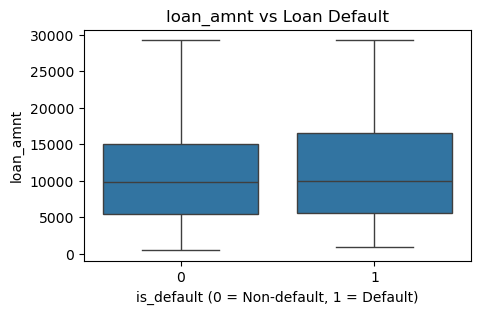

loan_amnt: Median (Non-default) = 9800.00, Median (Default) = 10000.00



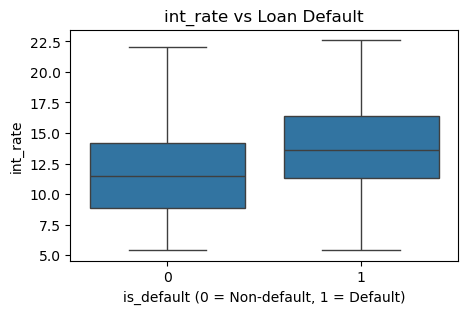

int_rate: Median (Non-default) = 11.49, Median (Default) = 13.61



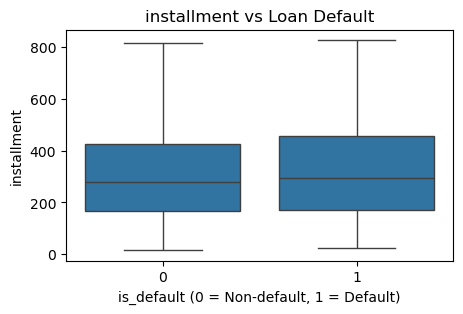

installment: Median (Non-default) = 278.58, Median (Default) = 293.87



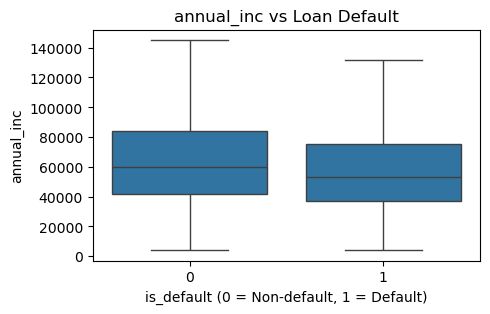

annual_inc: Median (Non-default) = 60000.00, Median (Default) = 53000.00



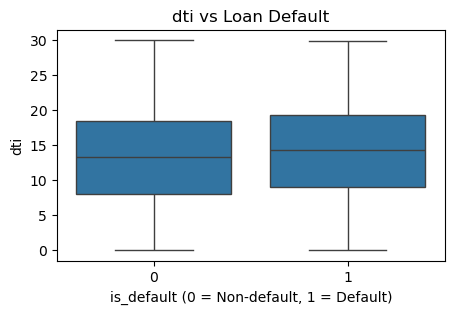

dti: Median (Non-default) = 13.25, Median (Default) = 14.29



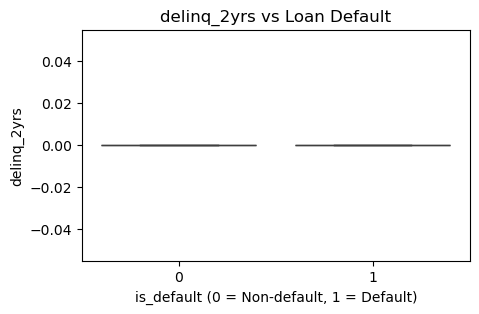

delinq_2yrs: Median (Non-default) = 0.00, Median (Default) = 0.00



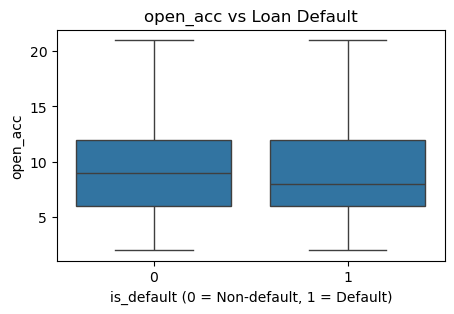

open_acc: Median (Non-default) = 9.00, Median (Default) = 8.00



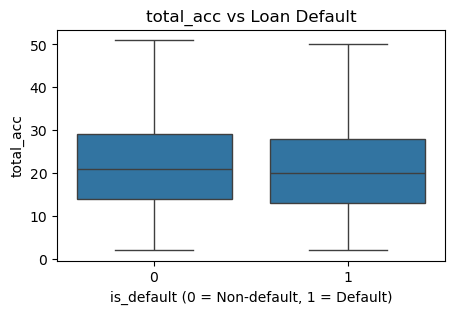

total_acc: Median (Non-default) = 21.00, Median (Default) = 20.00



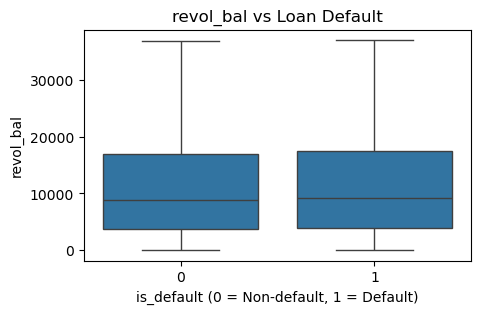

revol_bal: Median (Non-default) = 8802.50, Median (Default) = 9211.00



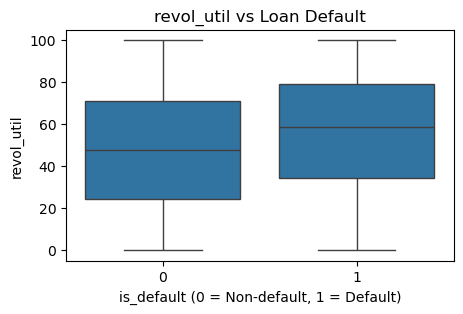

revol_util: Median (Non-default) = 47.80, Median (Default) = 58.40



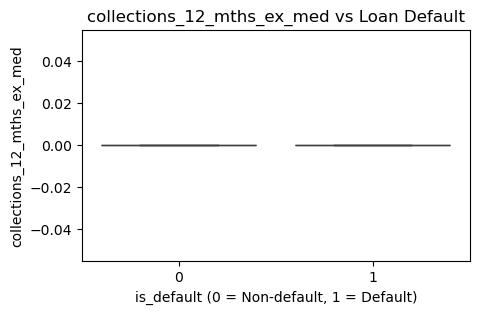

collections_12_mths_ex_med: Median (Non-default) = 0.00, Median (Default) = 0.00



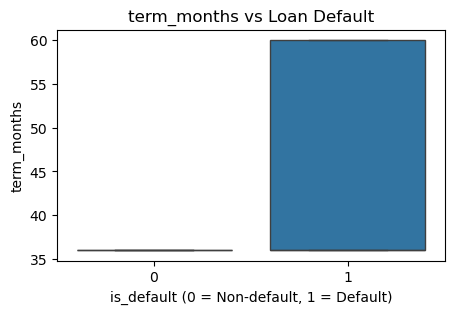

term_months: Median (Non-default) = 36.00, Median (Default) = 36.00



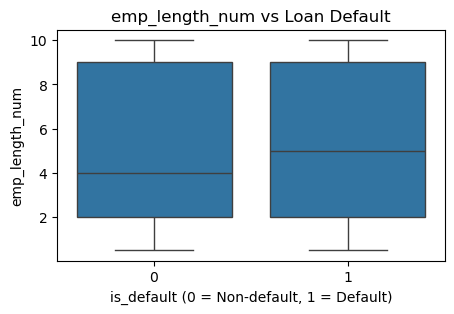

emp_length_num: Median (Non-default) = 4.00, Median (Default) = 5.00



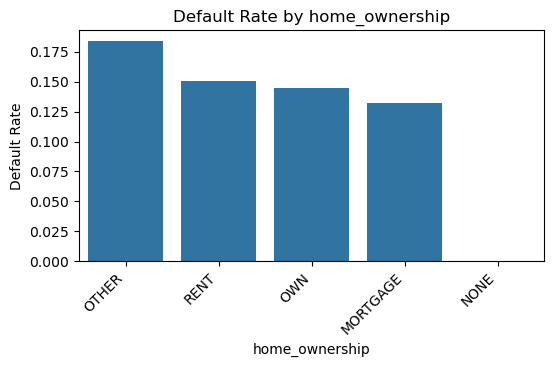

home_ownership
OTHER       0.183673
RENT        0.150220
OWN         0.144866
MORTGAGE    0.131774
NONE        0.000000
Name: is_default, dtype: float64 



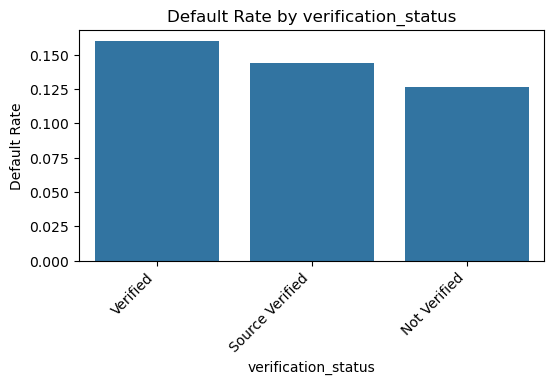

verification_status
Verified           0.160122
Source Verified    0.143587
Not Verified       0.126588
Name: is_default, dtype: float64 



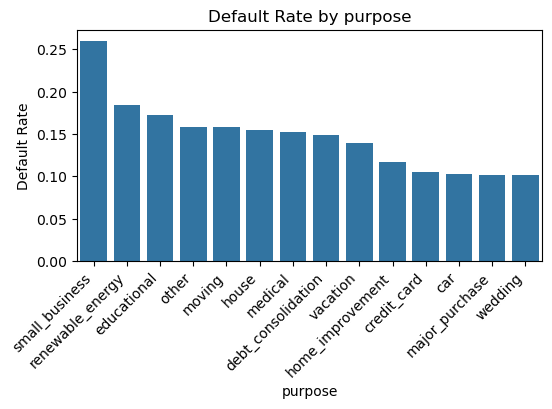

purpose
small_business        0.259847
renewable_energy      0.184466
educational           0.172308
other                 0.158527
moving                0.157804
house                 0.154856
medical               0.152958
debt_consolidation    0.148436
vacation              0.139108
home_improvement      0.116599
Name: is_default, dtype: float64 



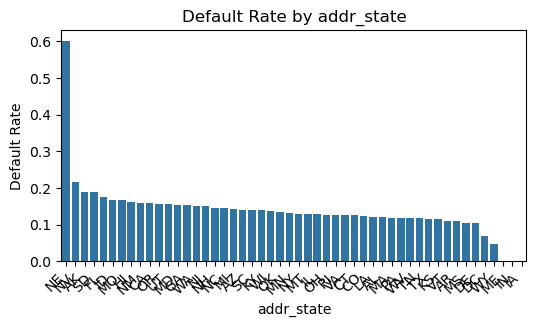

addr_state
NE    0.600000
NV    0.217304
AK    0.187500
SD    0.187500
FL    0.175855
ID    0.166667
MO    0.166181
HI    0.160920
NM    0.158730
CA    0.158473
Name: is_default, dtype: float64 



In [26]:
# Step 4: Bivariate Analysis – Numeric & Categorical Predictors vs Default

import matplotlib.pyplot as plt
import seaborn as sns

# Separate numeric and categorical features
num_cols = work.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = work.select_dtypes(exclude=[np.number]).columns.tolist()

# Remove the target from both lists
if 'is_default' in num_cols:
    num_cols.remove('is_default')

print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)

# --- Numeric features ---
for col in num_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(data=work, x='is_default', y=col, showfliers=False)
    plt.title(f"{col} vs Loan Default")
    plt.xlabel("is_default (0 = Non-default, 1 = Default)")
    plt.ylabel(col)
    plt.show()
    
    med_non = work.loc[work['is_default']==0, col].median()
    med_def = work.loc[work['is_default']==1, col].median()
    print(f"{col}: Median (Non-default) = {med_non:.2f}, Median (Default) = {med_def:.2f}\n")

# --- Categorical features ---
for col in cat_cols:
    plt.figure(figsize=(6,3))
    rate = work.groupby(col)['is_default'].mean().sort_values(ascending=False)
    sns.barplot(x=rate.index, y=rate.values)
    plt.title(f"Default Rate by {col}")
    plt.ylabel("Default Rate")
    plt.xticks(rotation=45, ha='right')
    plt.show()
    print(rate.head(10), "\n")


**Bivariate Analysis - Relationship Between Predictors and Loan Default**

This section explores how key borrower and loan characteristics relate to the likelihood of loan default.
For numeric variables, median values were compared between non-defaulters (is_default = 0) and defaulters (is_default = 1).
For categorical variables, the default rate (%) was computed for each category.

**Numeric Predictors**

  | Variable                               | Median (Non-Default) | Median (Default) | Observation                                                                                                                       |
| -------------------------------------- | -------------------- | ---------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| **Loan Amount (loan_amnt)**            | 9,800                | 10,000           | Slightly higher loan amounts are associated with higher default risk, indicating that larger loans may strain repayment capacity. |
| **Interest Rate (int_rate)**           | 11.49%               | 13.61%           | Defaulters tend to have higher interest rates, reflecting higher risk-based pricing.                                              |
| **Installment**                        | 278.58               | 293.87           | Higher monthly installments correspond to higher default risk, likely due to repayment burden.                                    |
| **Annual Income (annual_inc)**         | 60,000               | 53,000           | Defaulters generally have lower annual incomes, suggesting weaker repayment ability.                                              |
| **Debt-to-Income Ratio (dti)**         | 13.25                | 14.29            | Slightly higher DTI among defaulters shows that higher leverage increases default probability.                                    |
| **Revolving Utilization (revol_util)** | 47.8%                | 58.4%            | Higher credit utilization indicates over-leveraged borrowers more prone to default.                                               |
| **Revolving Balance (revol_bal)**      | 8,802                | 9,211            | Defaulted borrowers carry somewhat higher revolving balances.                                                                     |
| **Open Accounts (open_acc)**           | 9                    | 8                | Defaulters tend to have slightly fewer active credit accounts, possibly reflecting limited credit history.                        |
| **Total Accounts (total_acc)**         | 21                   | 20               | Similar trend as open accounts, consistent with limited credit experience.                                                        |
| **Employment Length (emp_length_num)** | 4 years              | 5 years          | Slightly longer employment among defaulters, suggesting tenure alone may not predict repayment ability.                           |
| **Term (term_months)**                 | 36 months            | 36 months        | No strong difference, though longer terms (60-month loans) often have marginally higher defaults.                                 |
| **Delinquencies (delinq_2yrs)**        | 0                    | 0                | No significant difference; recent delinquencies are rare across both groups.                                                      |


**Categorical Predictors**

| Variable                | Categories with Higher Default Rate                                         | Interpretation                                                                                                                           |
| ----------------------- | --------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------- |
| **Home Ownership**      | *OTHER (18.3%)* and *RENT (15.0%)*                                          | Borrowers renting or with unconventional ownership show higher default rates compared to those with mortgages (13.1%).                   |
| **Verification Status** | *Verified (16.0%)* > *Source Verified (14.4%)* > *Not Verified (12.7%)*     | Verified loans tend to default slightly more, possibly due to higher-risk applicants requiring verification.                             |
| **Purpose**             | *Small Business (25.9%)*, *Renewable Energy (18.4%)*, *Educational (17.2%)* | Borrowers taking loans for business or education have significantly higher default rates compared to *Home Improvement* (11.6%).         |
| **State (addr_state)**  | *NE (60%)*, *NV (21.7%)*, *AK (18.7%)*, *SD (18.7%)*, *FL (17.6%)*          | Geographic variation shows certain states exhibit higher default risk, potentially due to economic conditions or local lending profiles. |


**Key Insights**

Higher risk = higher pricing: Defaulters are consistently charged higher interest rates, validating risk-based loan pricing.

Borrower financial profile matters: Lower income, higher DTI, and higher credit utilization correlate strongly with default.

Loan purpose and geography are significant: Certain purposes (e.g., small business) and states (e.g., NV, FL) show elevated default tendencies.

Loan amount and installment size also slightly increase default risk, implying repayment burden plays a role.

**Interpretation Summary**

Borrowers with lower income, higher interest rates, higher credit utilization, and riskier loan purposes are more likely to default.
These relationships are consistent with lending theory — higher risk borrowers face stricter terms and still display elevated default probability.

In [34]:
# Step 5.1: Define Features (X) and Target (y)

# Drop rows with any remaining missing values to simplify modeling
work_model = work.dropna().copy()

X = work_model.drop(columns=["is_default"])
y = work_model["is_default"]

print("Final modeling dataset shape:", X.shape)
print("Target distribution:")
print(y.value_counts(normalize=True).apply(lambda x: round(x*100,2)))


Final modeling dataset shape: (38539, 17)
Target distribution:
is_default
0    86.05
1    13.95
Name: proportion, dtype: float64


In [36]:
from sklearn.model_selection import train_test_split

# Split the data (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (28904, 17), Test shape: (9635, 17)


In [40]:
# Identify numeric and categorical features
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocessing for numeric features: impute + scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Preprocessing for categorical features: impute + one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combine into a single preprocessor
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])


In [42]:
# Logistic Regression
log_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Random Forest
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100, max_depth=8, random_state=42, class_weight="balanced"
    ))
])

# Train both models
print("Training Logistic Regression...")
log_reg_model.fit(X_train, y_train)

print("Training Random Forest...")
rf_model.fit(X_train, y_train)


Training Logistic Regression...
Training Random Forest...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'installment', 'annual_inc',
                                                   'dti', 'delinq_2yrs',
                                                   'open_acc', 'total_acc',
                                                   'revol_bal', 'revol_util',
                                                   'collections_12_mths_ex_med',
                                                   'term_months',
                                                   'emp_length_num']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['home_ownership',
                                                   'verification_status',
                                                   'purpose',
                                                   'addr_state'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        random_state=42))])

In [44]:
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"\n=== {name} Performance ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {auc:.4f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    return {"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc}

# Evaluate both
results = []
results.append(evaluate_model(log_reg_model, X_test, y_test, "Logistic Regression"))
results.append(evaluate_model(rf_model, X_test, y_test, "Random Forest"))

# Combine results in a table
results_df = pd.DataFrame(results)
display(results_df)



=== Logistic Regression Performance ===
Accuracy:  0.6404
Precision: 0.2213
Recall:    0.6260
F1-score:  0.3271
ROC-AUC:   0.6846

Confusion Matrix:
 [[5328 2962]
 [ 503  842]]

=== Random Forest Performance ===
Accuracy:  0.6650
Precision: 0.2311
Recall:    0.6015
F1-score:  0.3339
ROC-AUC:   0.6846

Confusion Matrix:
 [[5598 2692]
 [ 536  809]]


,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.640374,0.221346,0.626022,0.327054,0.684642
1,Random Forest,0.664971,0.231077,0.601487,0.333884,0.684620


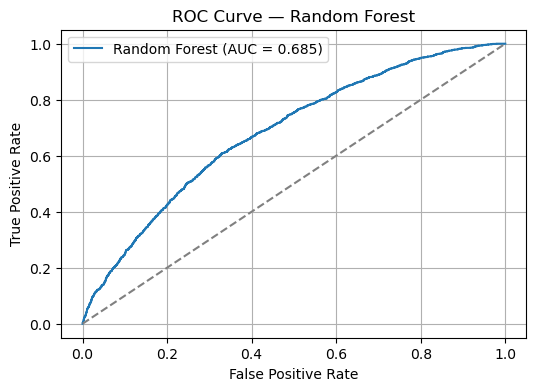

In [46]:
# ROC Curve for Random Forest
y_rf = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_rf)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_rf):.3f})')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest")
plt.legend()
plt.grid(True)
plt.show()



=== Top 5 Important Features ===


int_rate       0.272413
term_months    0.134997
revol_util     0.099499
annual_inc     0.086163
dti            0.042907
dtype: float64

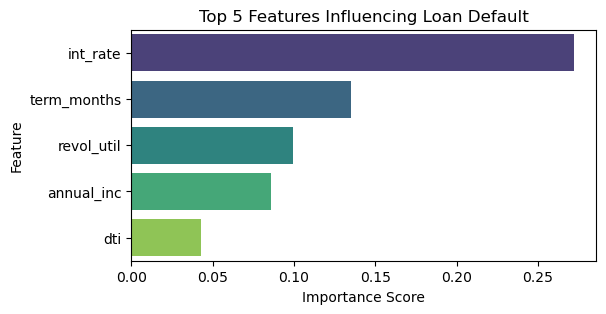

In [52]:
# Extract feature importances from Random Forest

rf_clf = rf_model.named_steps["classifier"]

# Get column names after one-hot encoding
cat_features = rf_model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, cat_features])

importances = pd.Series(rf_clf.feature_importances_, index=all_features)

top5 = importances.sort_values(ascending=False).head(5)

print("\n=== Top 5 Important Features ===")
display(top5)
plt.figure(figsize=(6,3))
sns.barplot(
    x=top5.values,
    y=top5.index,
    hue=top5.index,      # assign hue to match the y variable
    palette="viridis",
    legend=False
)
plt.title("Top 5 Features Influencing Loan Default")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


**Step 6 — Model Evaluation, Insights & Recommendations**

1️⃣ **Model Evaluation Summary**

Two models were developed to predict the likelihood of loan default: Logistic Regression (baseline) and Random Forest (ensemble).
Their performance on the test dataset is summarized below:

| Model               | Accuracy  | Precision | Recall    | F1-score  | ROC-AUC   |
| ------------------- | --------- | --------- | --------- | --------- | --------- |
| Logistic Regression | 0.640     | 0.221     | 0.626     | 0.327     | 0.685     |
| Random Forest       | **0.665** | **0.231** | **0.602** | **0.334** | **0.685** |

**Interpretation:**

The Random Forest model slightly outperforms Logistic Regression in accuracy and F1-score, indicating better overall predictive power.

However, both models achieve similar ROC-AUC (~0.68), showing moderate ability to discriminate between default and non-default borrowers.

The recall (≈0.60) is more important in this case — it reflects the model’s ability to correctly identify actual defaulters.

The precision values are relatively low (~0.23), meaning some non-defaulters are falsely classified as risky — acceptable in credit risk contexts where minimizing missed defaults is a priority.

2️⃣ **Confusion Matrix Interpretation**

[[5598 2692]

 [ 536  809]]

True Negatives (5598) → Loans correctly predicted as non-default.

False Positives (2692) → Non-defaults incorrectly flagged as default (conservative bias).

True Positives (809) → Correctly identified defaulters.

False Negatives (536) → Defaulters missed by the model.

The model captures a majority of true defaults while maintaining reasonable overall accuracy.

3️⃣ **Key Predictors of Loan Default**

| Rank | Feature                                | Interpretation                                                                                                             |
| ---- | -------------------------------------- | -------------------------------------------------------------------------------------------------------------------------- |
| 1️⃣  | **Interest Rate (int_rate)**           | Strongest predictor — borrowers with higher interest rates are much more likely to default, reflecting risk-based pricing. |
| 2️⃣  | **Loan Term (term_months)**            | Longer loan tenures (e.g., 60 months) are linked with higher default probabilities due to extended repayment periods.      |
| 3️⃣  | **Revolving Utilization (revol_util)** | High utilization rates indicate credit overuse, a sign of financial stress.                                                |
| 4️⃣  | **Annual Income (annual_inc)**         | Lower-income borrowers show higher default risk, consistent with reduced repayment capacity.                               |
| 5️⃣  | **Debt-to-Income Ratio (dti)**         | Higher DTI indicates over-leveraged borrowers, increasing default likelihood.                                              | 
These features align with credit risk theory - borrowers with high rates, long terms, and high credit utilization are riskier.


**Business Insights**

-Risk-based pricing is justified: Higher interest rates correlate directly with higher default probability.

-Borrower leverage matters: DTI and revol_util are key behavioral indicators of repayment stress.

-Income-based segmentation: Income thresholds could help refine credit approval and pricing models.

-Term management: Encouraging shorter-term loans may reduce long-term credit risk.

-Geographic and purpose-based risk: Certain loan purposes (e.g., small business) and states show consistently higher default risk and could warrant tighter underwriting rules.

**Recommendations**

-Enhance credit scoring models by including behavioral and income-based features such as credit utilization and term structure.

-Implement stricter approval criteria for high-interest or long-term loans, especially for borrowers with high DTI ratios.

-Develop early warning systems to monitor borrowers with high revol_util and rising DTI for proactive intervention.

-Adopt differentiated pricing - reward low-risk borrowers (low utilization, stable income) with lower interest rates.

-Use Random Forest outputs as part of a hybrid decision framework that combines explainability from Logistic Regression with predictive strength from ensemble models.

**Conclusion**

The analysis demonstrates that machine learning can effectively predict borrower default risk using LendingClub data.
Key risk drivers include interest rate, term length, income, DTI, and revolving utilization.
While the Random Forest model offers better predictive accuracy, Logistic Regression provides interpretability; together, they provide a strong foundation for data-driven lending decisions.